## Импорт необходимых библиотек

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import albumentations as A
from albumentations.pytorch import ToTensor
from sklearn.model_selection import train_test_split
import os
import re
import requests

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import random
from sklearn.metrics import classification_report

## Список классов заболеваний + лейблы датасета

In [2]:
classes = ["Nutrient surplus", "Magnesium", "phosphate", "Healthy", "Phosphorous", "nitrates", "potassium", "nitrogen", "calcium", "Sulfur"]
classes_labels = {
        "Nutrient surplus": [0],
        "Magnesium+phosphate": [1, 2],
        "Healthy": [3],
        "Phosphorous+magnesium": [4, 1],
        "nitrates+potassium": [5, 6],
        "nitrogen+potassium": [7, 6],
        "calcium+phosporous": [8, 4],
        "Sulfur+magnesium": [9, 1],
    }
print(len(classes_labels), len(classes))

8 10


## Некоторые вспомогательные функции
* `seed_everything` - функция закрепляющая seed для дальнейшей воспроизводимости экспериментов
* `get_path_names` - функция для парсинга папок датасета
* `encode_label` - функция энкодинга лейблов датасета
* `decode_target` - функция декодинга ответа модели по трешхолду
* `denorm` - функция денормализации тензоров
* `show_example` - функция для отображения элемента датасета 
* `show_batch` - функция для отображения батча изображений

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Making a list that contains the paths of each image
def get_path_names(dir):
    images = []
    for path, subdirs, files in os.walk(data_dir):
        for sub in subdirs:
            data_path = os.path.join(path, sub)
            import pdb;pdb.set_trace()
            for p, s, f in os.walk(data_path):
                for n in f:
                    images.append(os.path.join(p, n))
    return images

def encode_label(label, classes_list = classes): #encoding the classes into a tensor of shape (10) with 0 and 1s.
    target = torch.zeros(10)
    for l in eval(label):
        target[l] = 1
    return target


def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            result.append(classes[i])     
    return ' '.join(result)


def show_example(img,label):
    plt.imshow(img.permute(1, 2, 0))
    print("Label:", decode_target(label))
    print()
    print(label)
    
#let's see a batch of images (16 images) in a grid
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

seed_everything(42)

In [4]:
data_dir = "../input/gid-tower-final-dataset/final_cropped_dataset/final_cropped_dataset"
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))

['nitrogen+potassium', 'Phosphorous+magnesium', 'nitrates+potassium', 'Magnesium+phosphate', 'Nutrient surplus', 'Healthy', 'calcium+phosporous', 'Sulfur+magnesium']
8


## Считывание и преобразование csv файла датасета

In [5]:
df = pd.read_csv("../input/gidtowerdatasetmultilabel/dataset.csv/dataset.csv")
df = df[["imgs", "labels"]]
df

,imgs,labels
0,final_cropped_dataset/Nutrient surplus/63.jpg,[0]
1,final_cropped_dataset/Nutrient surplus/77.jpg,[0]
2,final_cropped_dataset/Nutrient surplus/76.jpg,[0]
3,final_cropped_dataset/Nutrient surplus/62.jpg,[0]
4,final_cropped_dataset/Nutrient surplus/74.jpg,[0]
...,...,...
713,final_cropped_dataset/Sulfur+magnesium/91.jpg,"[9, 1]"
714,final_cropped_dataset/Sulfur+magnesium/85.jpg,"[9, 1]"
715,final_cropped_dataset/Sulfur+magnesium/52.jpg,"[9, 1]"
716,final_cropped_dataset/Sulfur+magnesium/0.jpg,"[9, 1]"


#### В датасете есть сломанное изображение - берем все значения кроме сломанного

In [6]:
df = df[df["imgs"]!="final_cropped_dataset/Sulfur+magnesium/69.jpg"]
df = df[df["imgs"] != "final_cropped_dataset/Healthy/.DS_Store"]
df = df[df["imgs"] != "final_cropped_dataset/Nutrient surplus/.DS_Store"]
df = df[["imgs", "labels"]]
df = df.reset_index()
df

,index,imgs,labels
0,0,final_cropped_dataset/Nutrient surplus/63.jpg,[0]
1,1,final_cropped_dataset/Nutrient surplus/77.jpg,[0]
2,2,final_cropped_dataset/Nutrient surplus/76.jpg,[0]
3,3,final_cropped_dataset/Nutrient surplus/62.jpg,[0]
4,4,final_cropped_dataset/Nutrient surplus/74.jpg,[0]
...,...,...,...
710,713,final_cropped_dataset/Sulfur+magnesium/91.jpg,"[9, 1]"
711,714,final_cropped_dataset/Sulfur+magnesium/85.jpg,"[9, 1]"
712,715,final_cropped_dataset/Sulfur+magnesium/52.jpg,"[9, 1]"
713,716,final_cropped_dataset/Sulfur+magnesium/0.jpg,"[9, 1]"


In [7]:
train_df, test_df = train_test_split(df, random_state=42, stratify=df.labels, test_size=0.15)
train_df = train_df.reset_index()
test_df = test_df.reset_index()
test_df = test_df[["imgs", "labels"]]
train_df = train_df[["imgs", "labels"]]

In [8]:
train_df

,imgs,labels
0,final_cropped_dataset/Phosphorous+magnesium/43...,"[4, 1]"
1,final_cropped_dataset/calcium+phosporous/11.jpg,"[8, 4]"
2,final_cropped_dataset/calcium+phosporous/63.jpg,"[8, 4]"
3,final_cropped_dataset/Nutrient surplus/77.jpg,[0]
4,final_cropped_dataset/Healthy/59.jpg,[3]
...,...,...
602,final_cropped_dataset/calcium+phosporous/9.jpg,"[8, 4]"
603,final_cropped_dataset/Phosphorous+magnesium/31...,"[4, 1]"
604,final_cropped_dataset/Sulfur+magnesium/136.jpg,"[9, 1]"
605,final_cropped_dataset/nitrogen+potassium/74.jpg,"[7, 6]"


## Кастомный класс датасета

In [9]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.transform = transform
        self.df = df
        self.root_dir = root_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.root_dir + self.df["imgs"][idx]
        img = np.asarray(Image.open(img_path).convert("RGB"))
        labels = self.df["labels"][idx]
        if self.transform:
            img = self.transform(image=img)["image"]
        return torch.Tensor(img).permute(2, 1, 0), encode_label(labels)

## Аугментации, которые мы применим к изображениям датасета

In [10]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean and std values of the Imagenet Dataset so that pretrained models could also be used

train_transform = A.Compose([A.Resize(224, 224),
                      A.HorizontalFlip(0.5),
                      A.VerticalFlip(0.5),
                      A.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
#                       ToTensor(),
                      A.Normalize()])

val_transform = A.Compose([A.Resize(224, 224),
                      A.Normalize()])

In [11]:
#Creating a dataset that loads images from the specified directory, encode their labels and transforming them into tensors.
root_dir = "../input/gidtowerdatasetmultilabel/final_cropped_dataset/"

train_dataset = myDataset(train_df, root_dir=root_dir, transform = train_transform)
val_dataset = myDataset(test_df, root_dir=root_dir, transform = val_transform)
len(train_dataset)

607

Label: Phosphorous calcium

tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])


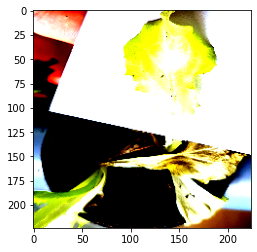

In [12]:
show_example(*val_dataset[12]) #let's take an example

## Создание Dataloader для использования batch-ей данных при обучении

In [13]:
#setting batch size for Dataloader to load the data batch by batch
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size * 2)

### Отображение батча 

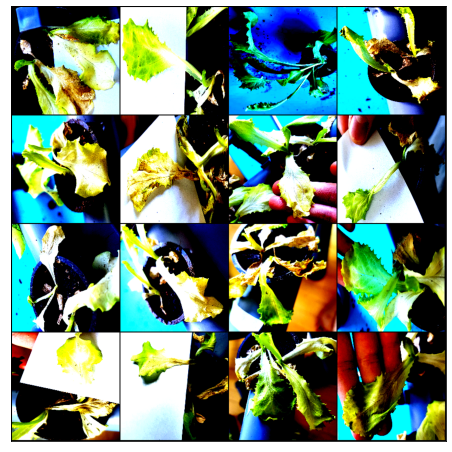

In [14]:
show_batch(val_loader)

## Класс с основными методами для Multilabel моделей

In [15]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """Get from training batch image and target, then push to model,
        finaly calculate loss
        """
        
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = F.binary_cross_entropy(out, targets)   # Calculate loss
        return loss    

    def validation_step(self, batch):
        """Get from val batch image and target, then push to model,
        compute loss and output arrays for metric count
        """
        
        pred_Y = []
        true_Y = []
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        pred_Y.append(np.array((out.detach().to("cpu") > 0.5).float()))
        true_Y.append(np.array(targets.detach().to("cpu").tolist()))
        return {'val_loss': loss.detach(), "metrics": (np.array(pred_Y), np.array(true_Y))}      


    def validation_epoch_end(self, outputs):
        """Count scores (losses, classification metrics) at the end of val epoch"""
        
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()      # Combine losses and get the mean value
        batch_scores = [x['metrics'] for x in outputs]
        pred_Y = [preds[0] for preds in batch_scores]
        final_preds = np.concatenate(pred_Y, axis=1)[0].tolist()
        true_Y = [preds[1] for preds in batch_scores]
        final_true = np.concatenate(true_Y, axis=1)[0].tolist()
        score = classification_report(final_preds, final_true, target_names=classes)
        print(score)
        return {'val_loss': epoch_loss.item()}    

    def epoch_end(self, epoch, result):                     # display the losses
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

## Вспомогательные функции и класс для размещения необходимого на GPU

In [16]:
#helper functions to load the data and model onto GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu') 


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [17]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

## Вспомогательные метода для обучения 
* `evaluate` - функция с шагом валидации модели
* `fit_one_cycle` - функция с циклом обучения модели (включая подсчет валидационных значений)

In [18]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Кастомные классы моделей 

In [19]:
from torch import nn
import torchvision as vision

class ResNet18(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        self.backbone = vision.models.resnet18(pretrained=True)
        classifier_name, old_classifier = self.backbone._modules.popitem()
        if isinstance(old_classifier, nn.Sequential):
            input_shape = old_classifier[-1].in_features
            old_classifier[-1] = nn.Linear(input_shape,num_classes)

        elif isinstance(old_classifier, nn.Linear):
            input_shape = old_classifier.in_features
            old_classifier = nn.Linear(input_shape,num_classes)
        else:
            raise Exception("Uknown type of classifier {}".format(type(old_classifier)))
        self.backbone.add_module(classifier_name, old_classifier)

    def forward(self, X):
        out = self.backbone(X)
        out = F.sigmoid(out)
        return out

class MobileNetV2(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        self.backbone = vision.models.mobilenet_v2(pretrained=True)
        classifier_name, old_classifier = self.backbone._modules.popitem()
        if isinstance(old_classifier, nn.Sequential):
            input_shape = old_classifier[-1].in_features
            old_classifier[-1] = nn.Linear(input_shape,num_classes)

        elif isinstance(old_classifier, nn.Linear):
            input_shape = old_classifier.in_features
            old_classifier = nn.Linear(input_shape,num_classes)
        else:
            raise Exception("Uknown type of classifier {}".format(type(old_classifier)))
        self.backbone.add_module(classifier_name, old_classifier)

    def forward(self, X):
        out = self.backbone(X)
        out = F.sigmoid(out)
        return out

In [20]:
model = to_device(MobileNetV2(3, len(classes)), device) #input size: 3, output size: 11, loading model onto GPU

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


## Проверка результатов коробочной (еще не обученной) модели

In [21]:
history = [evaluate(model, val_dl)]
history

                  precision    recall  f1-score   support

Nutrient surplus       0.50      0.11      0.18        27
       Magnesium       0.52      0.43      0.47        63
       phosphate       1.00      0.17      0.29        94
         Healthy       1.00      0.10      0.19       105
     Phosphorous       0.23      0.28      0.25        25
        nitrates       0.08      0.04      0.06        24
       potassium       0.71      0.22      0.34        76
        nitrogen       0.83      0.11      0.19        95
         calcium       1.00      0.14      0.25       107
          Sulfur       0.05      1.00      0.09         1

       micro avg       0.54      0.18      0.26       617
       macro avg       0.59      0.26      0.23       617
    weighted avg       0.80      0.18      0.26       617
     samples avg       0.56      0.17      0.26       617



[{'val_loss': 0.7262152433395386}]

### Параметры для обучения

In [22]:
epochs = 35
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-3
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)


                  precision    recall  f1-score   support

Nutrient surplus       0.17      0.50      0.25         2
       Magnesium       0.19      0.34      0.25        29
       phosphate       0.31      0.16      0.21        32
         Healthy       1.00      0.12      0.21        93
     Phosphorous       0.20      0.40      0.27        15
        nitrates       0.00      0.00      0.00         4
       potassium       0.00      0.00      0.00        14
        nitrogen       0.92      0.14      0.24        80
         calcium       0.53      0.18      0.27        44
          Sulfur       0.14      1.00      0.25         3

       micro avg       0.28      0.17      0.21       316
       macro avg       0.35      0.28      0.19       316
    weighted avg       0.66      0.17      0.22       316
     samples avg       0.31      0.17      0.21       316

Epoch [0], last_lr: 0.0000, train_loss: 0.6671, val_loss: 0.6395



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.29      0.54      0.37        28
       phosphate       0.06      0.08      0.07        12
         Healthy       1.00      0.19      0.32        57
     Phosphorous       0.07      0.29      0.11         7
        nitrates       0.00      0.00      0.00         0
       potassium       0.00      0.00      0.00         2
        nitrogen       0.50      0.17      0.25        36
         calcium       0.33      0.29      0.31        17
          Sulfur       0.19      1.00      0.32         4

       micro avg       0.22      0.27      0.24       163
       macro avg       0.24      0.26      0.18       163
    weighted avg       0.56      0.27      0.28       163
     samples avg       0.25      0.25      0.24       163

Epoch [1], last_lr: 0.0000, train_loss: 0.6144, val_loss: 0.5757



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.63      0.72      0.67        46
       phosphate       0.00      0.00      0.00         1
         Healthy       1.00      0.79      0.88        14
     Phosphorous       0.07      1.00      0.12         2
        nitrates       0.00      0.00      0.00         0
       potassium       0.00      0.00      0.00         0
        nitrogen       0.17      0.40      0.24         5
         calcium       0.00      0.00      0.00         1
          Sulfur       0.24      1.00      0.38         5

       micro avg       0.27      0.72      0.39        74
       macro avg       0.21      0.39      0.23        74
    weighted avg       0.61      0.72      0.63        74
     samples avg       0.30      0.43      0.34        74

Epoch [2], last_lr: 0.0000, train_loss: 0.5308, val_loss: 0.4861



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.73      0.69      0.71        55
       phosphate       0.00      0.00      0.00         0
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.10      0.75      0.18         4
        nitrates       0.00      0.00      0.00         0
       potassium       0.04      1.00      0.08         1
        nitrogen       0.00      0.00      0.00         0
         calcium       0.00      0.00      0.00         0
          Sulfur       0.38      1.00      0.55         8

       micro avg       0.31      0.77      0.44        79
       macro avg       0.23      0.44      0.25        79
    weighted avg       0.69      0.77      0.70        79
     samples avg       0.33      0.49      0.38        79

Epoch [3], last_lr: 0.0000, train_loss: 0.4345, val_loss: 0.3986



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.65      0.71      0.68        48
       phosphate       0.00      0.00      0.00         0
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.27      0.80      0.40        10
        nitrates       0.00      0.00      0.00         0
       potassium       0.25      0.75      0.38         8
        nitrogen       0.08      1.00      0.15         1
         calcium       0.00      0.00      0.00         0
          Sulfur       0.67      1.00      0.80        14

       micro avg       0.37      0.80      0.51        92
       macro avg       0.29      0.53      0.34        92
    weighted avg       0.61      0.80      0.67        92
     samples avg       0.39      0.53      0.44        92

Epoch [4], last_lr: 0.0000, train_loss: 0.3460, val_loss: 0.3279



                  precision    recall  f1-score   support

Nutrient surplus       0.00      0.00      0.00         0
       Magnesium       0.77      0.73      0.75        55
       phosphate       0.00      0.00      0.00         0
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.40      0.80      0.53        15
        nitrates       0.00      0.00      0.00         1
       potassium       0.54      0.87      0.67        15
        nitrogen       0.17      1.00      0.29         2
         calcium       0.00      0.00      0.00         0
          Sulfur       0.90      1.00      0.95        19

       micro avg       0.49      0.82      0.61       118
       macro avg       0.38      0.54      0.42       118
    weighted avg       0.72      0.82      0.75       118
     samples avg       0.50      0.66      0.55       118

Epoch [5], last_lr: 0.0001, train_loss: 0.2652, val_loss: 0.2693



                  precision    recall  f1-score   support

Nutrient surplus       0.17      1.00      0.29         1
       Magnesium       0.65      0.77      0.71        44
       phosphate       0.00      0.00      0.00         0
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.67      0.77      0.71        26
        nitrates       0.33      0.80      0.47         5
       potassium       0.75      0.82      0.78        22
        nitrogen       0.50      0.86      0.63         7
         calcium       0.27      0.80      0.40         5
          Sulfur       0.86      1.00      0.92        18

       micro avg       0.58      0.83      0.69       139
       macro avg       0.52      0.78      0.59       139
    weighted avg       0.69      0.83      0.75       139
     samples avg       0.59      0.69      0.62       139

Epoch [6], last_lr: 0.0001, train_loss: 0.2002, val_loss: 0.2449



                  precision    recall  f1-score   support

Nutrient surplus       0.33      1.00      0.50         2
       Magnesium       0.83      0.77      0.80        56
       phosphate       0.31      1.00      0.48         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.83      0.74      0.78        34
        nitrates       0.42      0.83      0.56         6
       potassium       0.67      0.94      0.78        17
        nitrogen       0.58      0.88      0.70         8
         calcium       0.47      1.00      0.64         7
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.71      0.85      0.77       166
       macro avg       0.64      0.92      0.72       166
    weighted avg       0.78      0.85      0.79       166
     samples avg       0.71      0.79      0.74       166

Epoch [7], last_lr: 0.0001, train_loss: 0.1280, val_loss: 0.2052



                  precision    recall  f1-score   support

Nutrient surplus       0.33      1.00      0.50         2
       Magnesium       0.79      0.75      0.77        55
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.83      0.66      0.74        38
        nitrates       0.42      0.83      0.56         6
       potassium       0.71      0.94      0.81        18
        nitrogen       0.67      0.89      0.76         9
         calcium       0.67      0.77      0.71        13
          Sulfur       1.00      1.00      1.00        21

       micro avg       0.72      0.81      0.77       177
       macro avg       0.67      0.88      0.72       177
    weighted avg       0.78      0.81      0.78       177
     samples avg       0.73      0.77      0.74       177

Epoch [8], last_lr: 0.0001, train_loss: 0.0805, val_loss: 0.1856



                  precision    recall  f1-score   support

Nutrient surplus       0.33      1.00      0.50         2
       Magnesium       0.79      0.79      0.79        52
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.70      0.78        37
        nitrates       0.50      0.86      0.63         7
       potassium       0.71      0.85      0.77        20
        nitrogen       0.75      0.90      0.82        10
         calcium       0.53      0.73      0.62        11
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.72      0.83      0.77       174
       macro avg       0.67      0.88      0.73       174
    weighted avg       0.78      0.83      0.79       174
     samples avg       0.73      0.77      0.74       174

Epoch [9], last_lr: 0.0001, train_loss: 0.0562, val_loss: 0.1884



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.85      0.86      0.85        51
       phosphate       0.12      1.00      0.22         2
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.93      0.65      0.77        43
        nitrates       0.42      0.83      0.56         6
       potassium       0.62      0.88      0.73        17
        nitrogen       0.75      0.90      0.82        10
         calcium       0.73      0.79      0.76        14
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.75      0.84      0.79       178
       macro avg       0.70      0.89      0.75       178
    weighted avg       0.83      0.84      0.82       178
     samples avg       0.76      0.81      0.77       178

Epoch [10], last_lr: 0.0001, train_loss: 0.0436, val_loss: 0.1876



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.75      0.89      0.81        44
       phosphate       0.12      1.00      0.22         2
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.83      0.71      0.77        35
        nitrates       0.50      0.86      0.63         7
       potassium       0.79      0.86      0.83        22
        nitrogen       0.75      0.90      0.82        10
         calcium       0.67      0.91      0.77        11
          Sulfur       0.95      0.95      0.95        21

       micro avg       0.73      0.87      0.79       167
       macro avg       0.70      0.91      0.76       167
    weighted avg       0.79      0.87      0.82       167
     samples avg       0.74      0.79      0.76       167

Epoch [11], last_lr: 0.0001, train_loss: 0.0296, val_loss: 0.1729



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.83      0.88      0.85        49
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.70      0.78        37
        nitrates       0.58      0.88      0.70         8
       potassium       0.75      0.90      0.82        20
        nitrogen       0.75      0.90      0.82        10
         calcium       0.73      0.92      0.81        12
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.77      0.87      0.82       175
       macro avg       0.74      0.92      0.80       175
    weighted avg       0.81      0.87      0.83       175
     samples avg       0.78      0.85      0.80       175

Epoch [12], last_lr: 0.0001, train_loss: 0.0231, val_loss: 0.1565



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.73      0.88      0.80        43
       phosphate       0.19      0.75      0.30         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.72      0.79        36
        nitrates       0.58      0.88      0.70         8
       potassium       0.75      0.78      0.77        23
        nitrogen       0.83      0.91      0.87        11
         calcium       0.60      0.75      0.67        12
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.73      0.85      0.79       172
       macro avg       0.72      0.87      0.77       172
    weighted avg       0.78      0.85      0.80       172
     samples avg       0.75      0.82      0.77       172

Epoch [13], last_lr: 0.0001, train_loss: 0.0208, val_loss: 0.1660



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.71      0.93      0.80        40
       phosphate       0.31      1.00      0.48         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.80      0.80      0.80        30
        nitrates       0.58      0.88      0.70         8
       potassium       0.83      0.87      0.85        23
        nitrogen       0.75      0.90      0.82        10
         calcium       0.60      0.82      0.69        11
          Sulfur       0.90      1.00      0.95        19

       micro avg       0.73      0.90      0.81       161
       macro avg       0.72      0.92      0.79       161
    weighted avg       0.76      0.90      0.82       161
     samples avg       0.74      0.83      0.77       161

Epoch [14], last_lr: 0.0001, train_loss: 0.0198, val_loss: 0.1713



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.83      0.88      0.85        49
       phosphate       0.38      1.00      0.55         6
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.73      0.76      0.75        29
        nitrates       0.50      0.86      0.63         7
       potassium       0.75      0.90      0.82        20
        nitrogen       0.92      0.92      0.92        12
         calcium       0.67      0.83      0.74        12
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.76      0.89      0.82       170
       macro avg       0.74      0.91      0.80       170
    weighted avg       0.79      0.89      0.83       170
     samples avg       0.77      0.81      0.78       170

Epoch [15], last_lr: 0.0001, train_loss: 0.0180, val_loss: 0.1596



                  precision    recall  f1-score   support

Nutrient surplus       0.50      1.00      0.67         3
       Magnesium       0.79      0.84      0.81        49
       phosphate       0.31      1.00      0.48         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.83      0.81      0.82        31
        nitrates       0.50      0.86      0.63         7
       potassium       0.88      0.91      0.89        23
        nitrogen       0.67      0.89      0.76         9
         calcium       0.80      0.80      0.80        15
          Sulfur       0.95      0.95      0.95        21

       micro avg       0.76      0.87      0.82       174
       macro avg       0.72      0.91      0.78       174
    weighted avg       0.81      0.87      0.83       174
     samples avg       0.77      0.81      0.78       174

Epoch [16], last_lr: 0.0001, train_loss: 0.0168, val_loss: 0.1807



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.79      0.87      0.83        47
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.70      0.78        37
        nitrates       0.50      0.86      0.63         7
       potassium       0.75      0.95      0.84        19
        nitrogen       0.83      0.91      0.87        11
         calcium       0.73      0.85      0.79        13
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.76      0.87      0.81       173
       macro avg       0.73      0.91      0.79       173
    weighted avg       0.81      0.87      0.83       173
     samples avg       0.77      0.83      0.79       173

Epoch [17], last_lr: 0.0001, train_loss: 0.0155, val_loss: 0.1643



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.87      0.88      0.87        51
       phosphate       0.19      1.00      0.32         3
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.76      0.81        34
        nitrates       0.67      0.89      0.76         9
       potassium       0.83      0.83      0.83        24
        nitrogen       0.83      0.83      0.83        12
         calcium       0.80      0.92      0.86        13
          Sulfur       0.95      0.95      0.95        21

       micro avg       0.80      0.87      0.83       182
       macro avg       0.77      0.91      0.80       182
    weighted avg       0.85      0.87      0.85       182
     samples avg       0.81      0.87      0.82       182

Epoch [18], last_lr: 0.0001, train_loss: 0.0138, val_loss: 0.1447



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.92      0.83      0.87        58
       phosphate       0.38      1.00      0.55         6
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.80      0.77      0.79        31
        nitrates       0.50      0.86      0.63         7
       potassium       0.79      0.95      0.86        20
        nitrogen       0.83      0.91      0.87        11
         calcium       0.40      1.00      0.57         6
          Sulfur       0.95      0.95      0.95        21

       micro avg       0.77      0.88      0.82       175
       macro avg       0.72      0.93      0.79       175
    weighted avg       0.83      0.88      0.84       175
     samples avg       0.78      0.84      0.80       175

Epoch [19], last_lr: 0.0001, train_loss: 0.0121, val_loss: 0.1496



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.84      0.86        55
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.72      0.79        36
        nitrates       0.58      0.88      0.70         8
       potassium       0.79      0.95      0.86        20
        nitrogen       0.75      0.90      0.82        10
         calcium       0.67      0.83      0.74        12
          Sulfur       0.95      0.95      0.95        21

       micro avg       0.78      0.86      0.82       181
       macro avg       0.74      0.91      0.79       181
    weighted avg       0.83      0.86      0.84       181
     samples avg       0.79      0.85      0.81       181

Epoch [20], last_lr: 0.0001, train_loss: 0.0112, val_loss: 0.1444



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.87      0.88      0.87        51
       phosphate       0.31      1.00      0.48         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.76      0.81        34
        nitrates       0.50      0.86      0.63         7
       potassium       0.79      0.95      0.86        20
        nitrogen       0.83      0.91      0.87        11
         calcium       0.80      0.80      0.80        15
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.79      0.89      0.84       178
       macro avg       0.76      0.92      0.81       178
    weighted avg       0.83      0.89      0.85       178
     samples avg       0.80      0.85      0.81       178

Epoch [21], last_lr: 0.0001, train_loss: 0.0126, val_loss: 0.1468



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.90      0.84      0.87        56
       phosphate       0.44      1.00      0.61         7
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.76      0.81        34
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.95      0.89        21
        nitrogen       0.83      0.91      0.87        11
         calcium       0.80      0.86      0.83        14
          Sulfur       1.00      0.95      0.98        22

       micro avg       0.82      0.88      0.85       187
       macro avg       0.78      0.91      0.83       187
    weighted avg       0.86      0.88      0.86       187
     samples avg       0.83      0.87      0.84       187

Epoch [22], last_lr: 0.0000, train_loss: 0.0086, val_loss: 0.1382



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.90      0.84      0.87        56
       phosphate       0.38      0.86      0.52         7
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.83      0.74      0.78        34
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.95      0.89        21
        nitrogen       0.75      0.90      0.82        10
         calcium       0.53      1.00      0.70         8
          Sulfur       1.00      1.00      1.00        21

       micro avg       0.79      0.88      0.83       179
       macro avg       0.74      0.91      0.80       179
    weighted avg       0.83      0.88      0.84       179
     samples avg       0.80      0.85      0.81       179

Epoch [23], last_lr: 0.0000, train_loss: 0.0098, val_loss: 0.1399



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.79      0.84        58
       phosphate       0.25      0.80      0.38         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.90      0.63      0.74        43
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.95      0.89        21
        nitrogen       0.75      0.90      0.82        10
         calcium       0.73      0.85      0.79        13
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.79      0.82      0.81       192
       macro avg       0.75      0.88      0.79       192
    weighted avg       0.84      0.82      0.82       192
     samples avg       0.80      0.81      0.80       192

Epoch [24], last_lr: 0.0000, train_loss: 0.0104, val_loss: 0.1446



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.88      0.88        52
       phosphate       0.25      0.80      0.38         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.80      0.77      0.79        31
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.91      0.87        22
        nitrogen       0.83      0.91      0.87        11
         calcium       0.53      0.80      0.64        10
          Sulfur       1.00      1.00      1.00        21

       micro avg       0.77      0.89      0.83       174
       macro avg       0.73      0.89      0.79       174
    weighted avg       0.82      0.89      0.84       174
     samples avg       0.78      0.84      0.80       174

Epoch [25], last_lr: 0.0000, train_loss: 0.0084, val_loss: 0.1371



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.83      0.96      0.89        45
       phosphate       0.12      1.00      0.22         2
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.90      0.69      0.78        39
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.91      0.87        22
        nitrogen       0.83      0.91      0.87        11
         calcium       0.93      0.78      0.85        18
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.79      0.88      0.83       179
       macro avg       0.76      0.91      0.79       179
    weighted avg       0.86      0.88      0.85       179
     samples avg       0.80      0.83      0.81       179

Epoch [26], last_lr: 0.0000, train_loss: 0.0077, val_loss: 0.1497



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.83      0.93      0.88        46
       phosphate       0.12      1.00      0.22         2
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.90      0.71      0.79        38
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.95      0.89        21
        nitrogen       0.92      0.92      0.92        12
         calcium       0.87      0.81      0.84        16
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.79      0.89      0.84       177
       macro avg       0.76      0.92      0.79       177
    weighted avg       0.85      0.89      0.86       177
     samples avg       0.80      0.84      0.81       177

Epoch [27], last_lr: 0.0000, train_loss: 0.0077, val_loss: 0.1462



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.87      0.88        53
       phosphate       0.31      1.00      0.48         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.77      0.77      0.77        30
        nitrates       0.58      0.88      0.70         8
       potassium       0.83      0.95      0.89        21
        nitrogen       0.92      0.92      0.92        12
         calcium       0.47      1.00      0.64         7
          Sulfur       1.00      1.00      1.00        21

       micro avg       0.78      0.90      0.84       172
       macro avg       0.74      0.94      0.81       172
    weighted avg       0.83      0.90      0.85       172
     samples avg       0.79      0.84      0.80       172

Epoch [28], last_lr: 0.0000, train_loss: 0.0069, val_loss: 0.1380



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.90      0.89        51
       phosphate       0.19      1.00      0.32         3
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.90      0.75      0.82        36
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.95      0.89        21
        nitrogen       0.83      0.91      0.87        11
         calcium       0.67      0.83      0.74        12
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.79      0.89      0.84       176
       macro avg       0.74      0.92      0.79       176
    weighted avg       0.85      0.89      0.86       176
     samples avg       0.80      0.85      0.81       176

Epoch [29], last_lr: 0.0000, train_loss: 0.0078, val_loss: 0.1391



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.88      0.88        52
       phosphate       0.19      1.00      0.32         3
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.90      0.75      0.82        36
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.91      0.87        22
        nitrogen       0.92      0.92      0.92        12
         calcium       0.53      0.89      0.67         9
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.78      0.89      0.83       176
       macro avg       0.74      0.92      0.79       176
    weighted avg       0.85      0.89      0.86       176
     samples avg       0.79      0.86      0.81       176

Epoch [30], last_lr: 0.0000, train_loss: 0.0072, val_loss: 0.1402



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.87      0.96      0.91        47
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.72      0.79        36
        nitrates       0.50      0.86      0.63         7
       potassium       0.83      0.91      0.87        22
        nitrogen       0.92      0.92      0.92        12
         calcium       0.87      0.81      0.84        16
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.80      0.89      0.85       179
       macro avg       0.77      0.92      0.81       179
    weighted avg       0.85      0.89      0.86       179
     samples avg       0.81      0.85      0.82       179

Epoch [31], last_lr: 0.0000, train_loss: 0.0086, val_loss: 0.1379



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.87      0.88        53
       phosphate       0.25      1.00      0.40         4
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.76      0.81        34
        nitrates       0.50      0.86      0.63         7
       potassium       0.79      0.95      0.86        20
        nitrogen       0.83      0.91      0.87        11
         calcium       0.53      1.00      0.70         8
          Sulfur       1.00      0.95      0.98        22

       micro avg       0.78      0.89      0.83       174
       macro avg       0.73      0.93      0.79       174
    weighted avg       0.84      0.89      0.85       174
     samples avg       0.79      0.85      0.81       174

Epoch [32], last_lr: 0.0000, train_loss: 0.0075, val_loss: 0.1424



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.75      0.97      0.85        40
       phosphate       0.12      1.00      0.22         2
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.90      0.73      0.81        37
        nitrates       0.67      0.89      0.76         9
       potassium       0.83      0.83      0.83        24
        nitrogen       0.83      0.91      0.87        11
         calcium       0.87      0.87      0.87        15
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.77      0.89      0.83       173
       macro avg       0.76      0.92      0.80       173
    weighted avg       0.83      0.89      0.85       173
     samples avg       0.78      0.84      0.80       173

Epoch [33], last_lr: 0.0000, train_loss: 0.0080, val_loss: 0.1416



                  precision    recall  f1-score   support

Nutrient surplus       0.67      1.00      0.80         4
       Magnesium       0.88      0.87      0.88        53
       phosphate       0.31      1.00      0.48         5
         Healthy       1.00      1.00      1.00        11
     Phosphorous       0.87      0.74      0.80        35
        nitrates       0.67      0.89      0.76         9
       potassium       0.83      0.91      0.87        22
        nitrogen       0.83      0.91      0.87        11
         calcium       0.80      0.86      0.83        14
          Sulfur       0.95      1.00      0.98        20

       micro avg       0.81      0.88      0.85       184
       macro avg       0.78      0.92      0.83       184
    weighted avg       0.85      0.88      0.86       184
     samples avg       0.82      0.86      0.83       184

Epoch [34], last_lr: 0.0000, train_loss: 0.0066, val_loss: 0.1366
CPU times: user 17min 53s, sys: 23.7 s, total: 18min 17s
Wal

## Сохранение модели
- В обычном .pth формате 
- В формате torchscript (конвертация модели)

In [24]:
model.to("cpu")
torch.save(model.state_dict(), "classif_model.pth")
net = torch.jit.script(model)
net.save("jit_model.pt")
model_jit = torch.load("jit_model.pt")

## Отображение результатов обучения в виде графиков

### Отображение Loss-а

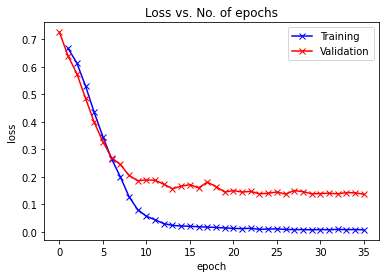

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

### Отображение learning rate

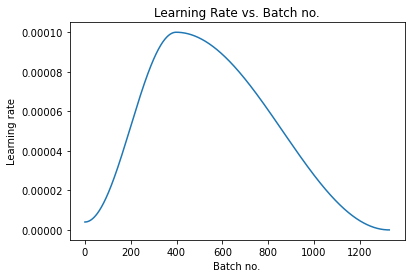

In [26]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

## Ручная проверка результатов обученной модели 

Label: Nutrient surplus

tensor([0.8783, 0.1286, 0.0908, 0.0049, 0.0013, 0.0146, 0.0034, 0.0013, 0.0045,
        0.0135], grad_fn=<SelectBackward>)


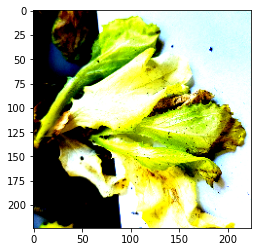

In [27]:
def predict_single(image):
    xb = image.unsqueeze(0)
    preds = model_jit(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[20][0]) #checking out the predictions of some images from the validation dataset.

Label: Magnesium Sulfur

tensor([3.6013e-03, 9.9786e-01, 4.7773e-03, 5.4231e-03, 8.3950e-04, 3.5339e-03,
        1.1770e-03, 1.2037e-03, 3.4706e-03, 9.9652e-01],
       grad_fn=<SelectBackward>)


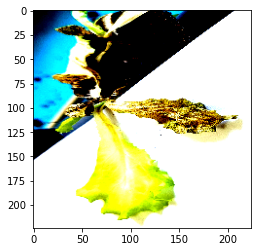

In [28]:
predict_single(val_dataset[45][0])

Label: Magnesium Sulfur

tensor([0.0039, 0.9722, 0.0133, 0.0063, 0.0262, 0.0029, 0.0448, 0.1178, 0.0154,
        0.8903], grad_fn=<SelectBackward>)


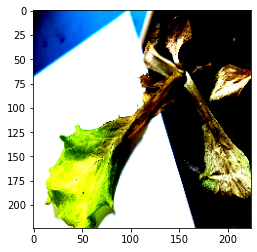

In [29]:
predict_single(val_dataset[100][0])

Label: Phosphorous calcium

tensor([0.0029, 0.0712, 0.0015, 0.0068, 0.9918, 0.1268, 0.0733, 0.0032, 0.6069,
        0.0038], grad_fn=<SelectBackward>)


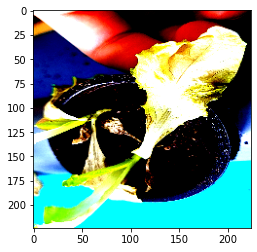

In [30]:
predict_single(val_dataset[70][0])